# Loading 60-20-20 Model

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf
tf.config.set_soft_device_placement(True)
tf.debugging.set_log_device_placement(True)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6739048193230697567
]


In [2]:
import tensorflow as tf
model = tf.keras.models.load_model('binaryairmass2(60,20,20)')

# Check its architecture
model.summary()

W1016 12:12:34.531901 47257545462656 deprecation.py:506] From /software/tensorflow/2.0.0b/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1016 12:12:34.534861 47257545462656 deprecation.py:506] From /software/tensorflow/2.0.0b/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1016 12:12:34.539151 47257545462656 deprecation.py:506] From /software/tensorflow/2.0.0b/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorf

Model: "SNnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Spec (InputLayer)      [(None, 150, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 150, 8)            48        
_________________________________________________________________
batch_normalization (BatchNo (None, 150, 8)            32        
_________________________________________________________________
activation (Activation)      (None, 150, 8)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 8)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 75, 16)            656       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 16)            64    

In [3]:
# from desispec.io import read_spectra
# from desitrip.preproc import rebin_flux, rescale_flux

from glob import glob
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import os
import platform

mpl.rc('font', size=14)

# Using model on airmass 2

In [4]:
## Input Spectra
import pickle 

with open('host_flux_airmass2.data', 'rb') as filehandle:
    host_flux = pickle.load(filehandle)

with open('snia_flux_airmass2.data', 'rb') as filehandle:
    # read the data as binary data stream
    snia_flux = pickle.load(filehandle)

nhost, nbins = host_flux.shape
nsnia, nbins = snia_flux.shape

nhost, nsnia, nbins

(9959, 9945, 150)

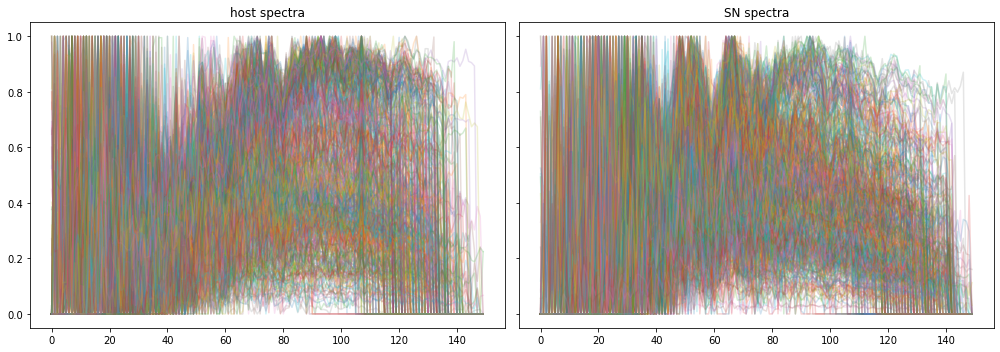

In [5]:
### Plot Spectra to Check Output

fig, axes = plt.subplots(1,2, figsize=(14,5), sharex=True, sharey=True)

for i in range(0,500):
    
    ax = axes[0]
    ax.plot(host_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
axes[0].set_title('host spectra')
axes[1].set_title('SN spectra')

fig.tight_layout()




In [21]:

### Set up Training Sets and Labels

# 0. "host" spectra based only on BGS templates
# 1. "snia" spectra based on BGS + SN Ia templates

x = np.concatenate([host_flux, snia_flux]).reshape(-1, nbins, 1)
y = np.concatenate([np.zeros(nhost), np.ones(nsnia)])

nhost, nbins = host_flux.shape
nsnia, nbins = snia_flux.shape

nhost, nsnia, nbins

x = np.concatenate([host_flux, snia_flux]).reshape(-1, nbins, 1)
y = np.concatenate([np.zeros(nhost), np.ones(nsnia)])

In [22]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
x = np.concatenate([host_flux, snia_flux]).reshape(-1, nbins, 1)
y = np.concatenate([np.zeros(nhost), np.ones(nsnia)])

In [23]:
def split(trainsize,x,y):
    from sklearn.model_selection import train_test_split
    """This function splits x, y into train, test, cv
    cv and test are equally split"""
    n = trainsize
    # here a, b are (1-n) fraction of x, y
    x_train, a, y_train, b = train_test_split(x, y, train_size=n)
    # now we split a, b into half to get cv and test
    x_cv, x_test, y_cv, y_test = train_test_split(a,b, test_size=0.5)
    return x_train, x_test, x_cv,y_train, y_test, y_cv

In [26]:
x_train, x_test, x_cv,y_train, y_test, y_cv = split(0.6,x,y)
len(x_train), len(x_test), len(x_cv),len(y_train), len(y_test), len(y_cv)

(11959, 3987, 3987, 11959, 3987, 3987)

In [27]:
hist = model.evaluate(x_test, y_test)

3987/3987 [==============================] - 1s 153us/sample - loss: 0.6373 - acc: 0.8440


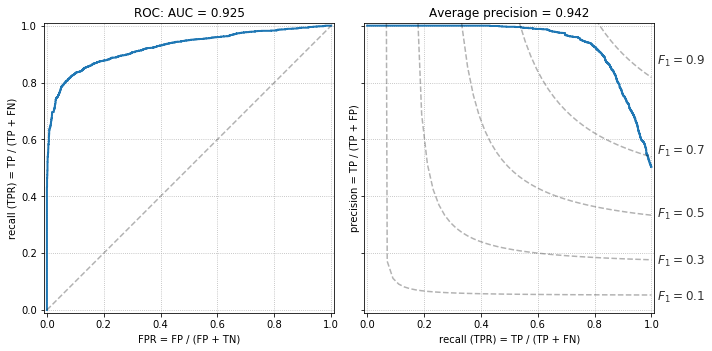

In [28]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
y_pred = model.predict(x_cv).ravel()
fpr, tpr, thresholds = roc_curve(y_cv, y_pred)
pre, rec, _ = precision_recall_curve(y_cv, y_pred)

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

ax = axes[0]
ax.plot(fpr, tpr, lw=2)
ax.plot((0,1), (0,1), 'k--', alpha=0.3)
ax.grid(ls=':')
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(auc(fpr, tpr)),
       aspect='equal')

ax = axes[1]
ax.plot(rec, pre, lw=2)
f_scores = np.linspace(0.1, 0.9, num=5)
lines = []
labels = []
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_cv, y_pred)),
       aspect='equal')

fig.tight_layout()

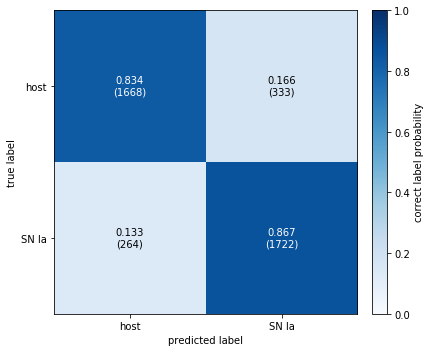

In [29]:
## <font color='red'>CM with y_pred > 0.5</font> 

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_cv, y_pred > 0.5)
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label probability')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=['host', 'SN Ia'],
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=['host', 'SN Ia'])

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([1.5,-.5])
fig.tight_layout()

# Using model on airmass-1 snia, host

In [30]:
import pickle 

with open('host_flux.data', 'rb') as filehandle:
    host_flux = pickle.load(filehandle)

with open('snia_flux.data', 'rb') as filehandle:
    # read the data as binary data stream
    snia_flux = pickle.load(filehandle)

nhost, nbins = host_flux.shape
nsnia, nbins = snia_flux.shape

In [31]:
### Set up Training Sets and Labels

# 0. "host" spectra based only on BGS templates
# 1. "snia" spectra based on BGS + SN Ia templates

x = np.concatenate([host_flux, snia_flux]).reshape(-1, nbins, 1)
y = np.concatenate([np.zeros(nhost), np.ones(nsnia)])

nhost, nbins = host_flux.shape
nsnia, nbins = snia_flux.shape

nhost, nsnia, nbins

(9969, 9964, 150)

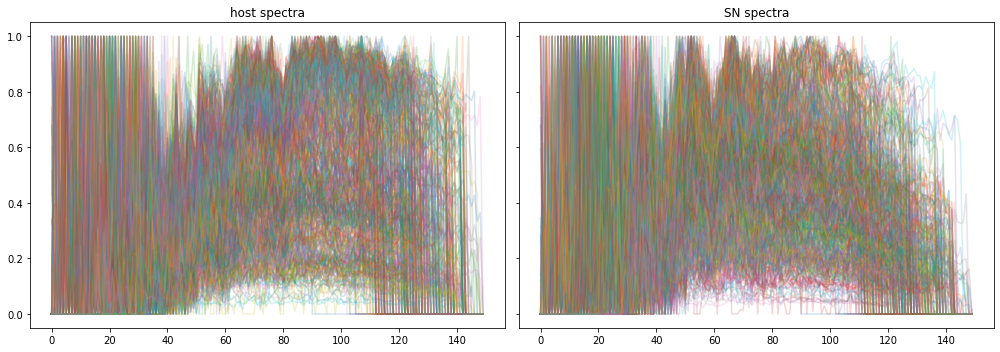

In [32]:
### Plot Spectra to Check Output

fig, axes = plt.subplots(1,2, figsize=(14,5), sharex=True, sharey=True)

for i in range(0,500):
    
    ax = axes[0]
    ax.plot(host_flux[i], alpha=0.2)

    ax = axes[1]
    ax.plot(snia_flux[i], alpha=0.2)
    
axes[0].set_title('host spectra')
axes[1].set_title('SN spectra')

fig.tight_layout()

In [33]:
x = np.concatenate([host_flux, snia_flux]).reshape(-1, nbins, 1)
y = np.concatenate([np.zeros(nhost), np.ones(nsnia)])

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
x = np.concatenate([host_flux, snia_flux]).reshape(-1, nbins, 1)
y = np.concatenate([np.zeros(nhost), np.ones(nsnia)])

In [35]:
hist = model.evaluate(x_test, y_test)

3987/3987 [==============================] - 1s 152us/sample - loss: 0.6335 - acc: 0.8440


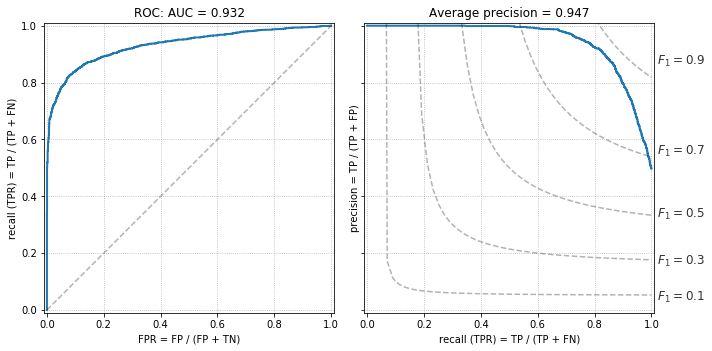

In [36]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
y_pred = model.predict(x_cv).ravel()
fpr, tpr, thresholds = roc_curve(y_cv, y_pred)
pre, rec, _ = precision_recall_curve(y_cv, y_pred)

fig, axes = plt.subplots(1,2, figsize=(10,5), sharex=True, sharey=True)

ax = axes[0]
ax.plot(fpr, tpr, lw=2)
ax.plot((0,1), (0,1), 'k--', alpha=0.3)
ax.grid(ls=':')
ax.set(xlim=(-0.01,1.01), xlabel='FPR = FP / (FP + TN)',
       ylim=(-0.01,1.01), ylabel='recall (TPR) = TP / (TP + FN)',
       title='ROC: AUC = {:.3f}'.format(auc(fpr, tpr)),
       aspect='equal')

ax = axes[1]
ax.plot(rec, pre, lw=2)
f_scores = np.linspace(0.1, 0.9, num=5)
lines = []
labels = []
for f_score in f_scores:
    x_ = np.linspace(0.01, 1)
    y_ = f_score * x_ / (2 * x_ - f_score)
    l, = plt.plot(x_[y_ >= 0], y_[y_ >= 0], color='k', ls='--', alpha=0.3)
    ax.annotate(' $F_{{1}}={0:0.1f}$'.format(f_score), xy=(1.01, y_[45]-0.02),
                fontsize=12, alpha=0.8)
ax.grid(ls=':')
ax.set(xlabel='recall (TPR) = TP / (TP + FN)',
       ylabel='precision = TP / (TP + FP)',
       title='Average precision = {:.3f}'.format(average_precision_score(y_cv, y_pred)),
       aspect='equal')

fig.tight_layout()

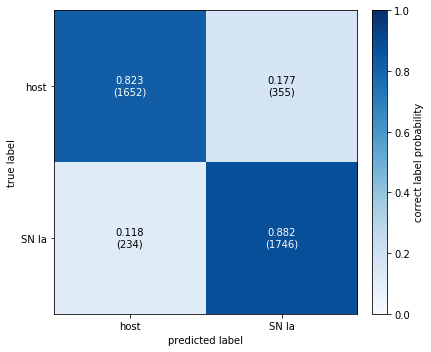

In [37]:
## <font color='red'>CM with y_pred > 0.5</font> 

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_cv, y_pred > 0.5)
cmnorm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1,1, figsize=(6,5))

im = ax.imshow(cmnorm, cmap='Blues', vmin=0, vmax=1)
cb = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cb.set_label('correct label probability')

ax.set(aspect='equal',
       xlabel='predicted label',
       xticks=np.arange(cm.shape[1]),
       xticklabels=['host', 'SN Ia'],
       ylabel='true label',
       yticks=np.arange(cm.shape[1]),
       yticklabels=['host', 'SN Ia'])

thresh = 0.5*cm.max()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, '{:.3f}\n({:d})'.format(cmnorm[i,j], cm[i,j]),
                ha='center', va='center',
                color='black' if cm[i,j] < thresh else 'white')
plt.ylim([1.5,-.5])
fig.tight_layout()